# MoE Prototype: XD Flavor Embedding (Taste • Aroma • Texture)

This notebook builds an **MoE-style prototype** from `final.csv` and **experimentally compares** alternatives at each step to justify choices. It assumes your prior pipeline wrote `final.csv` here:

- **Input**: `project_x/data_cleaned/final.csv`
- **Outputs** (saved alongside input):
  - `project_x/data_cleaned/moe_embeddings.csv`
  - `project_x/data_cleaned/moe_config.json`
  - Figures under `project_x/data_cleaned/figs/`

**Rules followed in this notebook:**
- For every standard choice (e.g., PCA components), we **try multiple options** (e.g., 2, 3, 4) and pick based on metrics.
- We explain *why* a choice was selected using the experiment results.
- Plots use **matplotlib** only and do **not** specify colors; legends/labels only.

In [3]:
# Imports & paths
from pathlib import Path
import os, re, json, math, random
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Resolve project root and data_cleaned
cwd = Path.cwd()
if (cwd / 'data_cleaned').exists():
    ROOT = cwd
else:
    # climb up to 5 levels to find data_cleaned
    ROOT = None
    search = cwd
    for _ in range(5):
        if (search / 'data_cleaned').exists():
            ROOT = search
            break
        search = search.parent
    if ROOT is None:
        ROOT = cwd

DATA_CLEANED = ROOT / 'data_cleaned'
INPUT_CSV = DATA_CLEANED / 'final.csv'
FIG_DIR = DATA_CLEANED / 'figs'
FIG_DIR.mkdir(parents=True, exist_ok=True)

print('ROOT:', ROOT)
print('INPUT:', INPUT_CSV)
assert INPUT_CSV.exists(), f"Missing final.csv at {INPUT_CSV}"

df = pd.read_csv(INPUT_CSV)
assert 'dish_description_clean' in df.columns, 'dish_description_clean column missing'
print('Rows:', len(df))
df.head(3)

ROOT: /Users/sarveshaks/Documents/Documents - Sarvesha’s MacBook Pro (2)/Project Stea/project_x
INPUT: /Users/sarveshaks/Documents/Documents - Sarvesha’s MacBook Pro (2)/Project Stea/project_x/data_cleaned/final.csv
Rows: 382


,city_name,restaurant_name,request_time_local,final_delivery_time_local,order_status,dish_name,item_quantity,customizations,customization_cost_local,special_instructions,...,order_price,currency,restaurant_tokens,dish_name_clean,customization_clean,dish_name_to_be_processed,dish_description,sugar_level,sodium_level,dish_description_clean
0,Portland,Gyro Kingdom (NE Davis),2024-12-01T02:37:08.000Z,2024-12-01T02:56:34.000Z,completed,Chicken shawarma gyro,1.0,Spicy Sauce,0.0,NaN,...,70.8,USD,"{'gyro', 'kingdom', 'davis'}",chicken shawarma,spicy sauce,chicken shawarma spicy sauce,The chicken shawarma gyro offers a savory tast...,NaN,NaN,the chicken shawarma offers savory taste with ...
1,Portland,Gyro Kingdom (NE Davis),2024-12-01T02:37:08.000Z,2024-12-01T02:56:34.000Z,completed,Crispy Fries,1.0,NaN,NaN,NaN,...,70.8,USD,"{'gyro', 'kingdom', 'davis'}",crispy fries,NaN,crispy fries,These crispy fries offer a satisfying crunch w...,NaN,NaN,these crispy fries offer satisfying crunch wit...
2,Portland,Gyro Kingdom (NE Davis),2024-12-01T02:37:08.000Z,2024-12-01T02:56:34.000Z,completed,Chicken Shawarma Plate,1.0,NaN,NaN,NaN,...,70.8,USD,"{'gyro', 'kingdom', 'davis'}",chicken shawarma plate,NaN,chicken shawarma plate,"The Chicken Shawarma Plate features tender, su...",NaN,NaN,the chicken shawarma plate features tender suc...


In [7]:
# === Replace your entire coverage block with THIS ===
from typing import List
import re
import pandas as pd

# 1) Expanded cue lexicons (same spirit, a bit broader)
taste_words = [
    "sweet","salty","sour","bitter","umami","savory","spicy","heat","pepper","tangy",
    "bittersweet","smoky","smokey","caramelized","honeyed"
]
aroma_words = [
    "garlic","garlicky","onion","oniony","butter","buttery","nutty","toasty","roasted","charred",
    "woody","earthy","floral","herb","herbal","basil","oregano","thyme","rosemary","dill","mint",
    "cumin","coriander","fennel","anise","clove","cardamom","cinnamon","sesame","peanut","peanutty",
    "coconut","coconutty","lemongrass","kaffir lime","lime","vinegar","fragrant","aroma","paprika",
    "ginger","turmeric","curry"
]
texture_words = [
    "crispy","crunchy","crackly","airy","flaky","tender","juicy","succulent","springy","bouncy",
    "toothsome","al dente","silky","smooth","velvety","thick","coarse","crumbly","sticky","gooey",
    "saucy","glaze","glaze-coated","creamy","chewy"
]

# 2) Build REGEX patterns correctly (fixes the earlier \\b issue and adds light variants)
def build_pattern(words: List[str]) -> re.Pattern:
    opts = []
    for w in words:
        if w in {"garlic","onion","butter"}:
            # garlicky, oniony, buttery
            opts.append(rf"\b{w}(y)?\b")
        elif w in {"smoky","smokey"}:
            # smoky/smokey/smoked/smoke…
            opts.append(rf"\bsmok(e|y)\w*\b")
        elif w in {"pepper"}:
            # pepper, peppery, peppered
            opts.append(rf"\bpepper(y|ed)?\b")
        elif w in {"roasted","charred","toasty"}:
            # already inflected; still allow suffixes safely
            root = w[:-2] if w.endswith("ed") else w
            opts.append(rf"\b{root}\w*\b")
        elif w in {"crispy","crunchy","chewy","creamy","silky","velvety","tender","juicy","flaky","sticky","gooey","saucy","smooth","coarse","crumbly"}:
            # texture adjectives — match their -y form explicitly
            root = w.rstrip("y")
            opts.append(rf"\b{root}y\b")
        elif " " in w:
            # phrases like "al dente", "kaffir lime"
            w2 = r"\s+".join(map(re.escape, w.split()))
            opts.append(rf"\b{w2}\b")
        else:
            opts.append(rf"\b{re.escape(w)}\b")
    return re.compile("|".join(opts), flags=re.IGNORECASE)

taste_pat   = build_pattern(taste_words)
aroma_pat   = build_pattern(aroma_words)
texture_pat = build_pattern(texture_words)

# 3) Apply to your dataframe column
# NOTE: df must already be loaded and contain 'dish_description_clean'
texts = df["dish_description_clean"].fillna("").astype(str)

df["has_taste"]   = texts.str.contains(taste_pat, regex=True)
df["has_aroma"]   = texts.str.contains(aroma_pat, regex=True)
df["has_texture"] = texts.str.contains(texture_pat, regex=True)

# 4) Filter rows having all three dimensions
df_all = df[df["has_taste"] & df["has_aroma"] & df["has_texture"]].copy().reset_index(drop=True)

# 5) Quick coverage print + optional save (you can keep or remove the save)
total = len(df)
print("Filtered rows with all three dimensions:", len(df_all), "of", total)
df_all[["dish_description_clean"]].head(3)

# Optional: save a filtered file for downstream use
FILTERED_PATH = DATA_CLEANED / "final_filtered_all3.csv"
df_all.to_csv(FILTERED_PATH, index=False)
print("Saved filtered file to:", FILTERED_PATH)


Filtered rows with all three dimensions: 336 of 382
Saved filtered file to: /Users/sarveshaks/Documents/Documents - Sarvesha’s MacBook Pro (2)/Project Stea/project_x/data_cleaned/final_filtered_all3.csv


/var/folders/gq/_54kskxn69x7bbbx_s277bdw0000gn/T/ipykernel_6790/3946489049.py:61: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_taste"]   = texts.str.contains(taste_pat, regex=True)
/var/folders/gq/_54kskxn69x7bbbx_s277bdw0000gn/T/ipykernel_6790/3946489049.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_aroma"]   = texts.str.contains(aroma_pat, regex=True)


## Step 1 — Build pseudo-labels for router training
We need a **router** that decides how much each expert (taste, aroma, texture) contributes. For a quick prototype, we derive a **dominant label** from cue counts and train the router to predict it from text features.

In [8]:
# Dominant label by cue counts
def count_hits(text: str, terms: List[str]) -> int:
    if not isinstance(text, str): return 0
    t = text.lower()
    return sum(1 for w in terms if re.search(r"\\b"+re.escape(w)+r"\\b", t))

df_all['taste_hits'] = df_all['dish_description_clean'].apply(lambda s: count_hits(s, taste_terms))
df_all['aroma_hits'] = df_all['dish_description_clean'].apply(lambda s: count_hits(s, aroma_terms))
df_all['texture_hits'] = df_all['dish_description_clean'].apply(lambda s: count_hits(s, texture_terms))
hit_cols = ['taste_hits','aroma_hits','texture_hits']
df_all['dominant'] = df_all[hit_cols].idxmax(axis=1).str.replace('_hits','', regex=False)
df_all['dominant'].value_counts()

dominant
taste    336
Name: count, dtype: int64

## Step 2 — Vectorizer experiments
We compare **TF-IDF configs** and pick the one that yields the best **router validation accuracy** (stratified split).

In [12]:
# --- Robust router setup with single-class fallback + unsupervised vectorizer selection ---

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, StratifiedKFold
import numpy as np
import pandas as pd
import re

# 0) Prepare inputs
X_text = df_all['dish_description_clean'].astype(str).tolist()

# If taste/aroma/texture counts weren't computed earlier in your notebook, compute them now.
def build_pattern(words):
    opts = []
    for w in words:
        if w in {"garlic","onion","butter"}:
            opts.append(rf"\b{w}(y)?\b")
        elif w in {"smoky","smokey"}:
            opts.append(rf"\bsmok(e|y)\w*\b")
        elif w in {"pepper"}:
            opts.append(rf"\bpepper(y|ed)?\b")
        elif w in {"roasted","charred","toasty"}:
            root = w[:-2] if w.endswith("ed") else w
            opts.append(rf"\b{root}\w*\b")
        elif w in {"crispy","crunchy","chewy","creamy","silky","velvety","tender","juicy","flaky","sticky","gooey","saucy","smooth","coarse","crumbly"}:
            root = w.rstrip("y")
            opts.append(rf"\b{root}y\b")
        elif " " in w:
            w2 = r"\s+".join(map(re.escape, w.split()))
            opts.append(rf"\b{w2}\b")
        else:
            opts.append(rf"\b{re.escape(w)}\b")
    return re.compile("|".join(opts), flags=re.IGNORECASE)

taste_words = ["sweet","salty","sour","bitter","umami","savory","spicy","heat","pepper","tangy","bittersweet","smoky","smokey","caramelized","honeyed"]
aroma_words = ["garlic","garlicky","onion","oniony","butter","buttery","nutty","toasty","roasted","charred","woody","earthy","floral","herb","herbal",
               "basil","oregano","thyme","rosemary","dill","mint","cumin","coriander","fennel","anise","clove","cardamom","cinnamon","sesame","peanut",
               "peanutty","coconut","coconutty","lemongrass","kaffir lime","lime","vinegar","fragrant","aroma","paprika","ginger","turmeric","curry"]
texture_words = ["crispy","crunchy","crackly","airy","flaky","tender","juicy","succulent","springy","bouncy","toothsome","al dente",
                 "silky","smooth","velvety","thick","coarse","crumbly","sticky","gooey","saucy","glaze","glaze-coated","creamy","chewy"]

taste_pat   = build_pattern(taste_words)
aroma_pat   = build_pattern(aroma_words)
texture_pat = build_pattern(texture_words)

def count_hits(text, pat):
    return int(bool(re.search(pat, text)))  # presence; you can use frequency if you want stronger weighting

# compute per-row presence (or frequency if desired)
df_all['taste_hits']   = df_all['dish_description_clean'].apply(lambda s: len(re.findall(taste_pat, s)))
df_all['aroma_hits']   = df_all['dish_description_clean'].apply(lambda s: len(re.findall(aroma_pat, s)))
df_all['texture_hits'] = df_all['dish_description_clean'].apply(lambda s: len(re.findall(texture_pat, s)))

# 1) Build dominant labels (for when we DO have ≥2 classes)
df_all['dominant'] = df_all[['taste_hits','aroma_hits','texture_hits']].idxmax(axis=1).str.replace('_hits','', regex=False)
y = df_all['dominant'].map({'taste':0,'aroma':1,'texture':2}).values
classes = np.unique(y)

# 2) Vectorizer options
vec_options = [
    {'ngram_range':(1,1), 'min_df':2, 'max_df':0.95, 'max_features':3000},
    {'ngram_range':(1,2), 'min_df':2, 'max_df':0.95, 'max_features':3000},
    {'ngram_range':(1,2), 'min_df':3, 'max_df':0.90, 'max_features':5000},
]

results_rows = []

if len(classes) >= 2:
    # ---------- Normal path: supervised validation ----------
    def get_split_or_cv(X_text, y, try_test_sizes=(0.2, 0.25, 0.3), n_tries=20):
        for test_size in try_test_sizes:
            sss = StratifiedShuffleSplit(n_splits=n_tries, test_size=test_size, random_state=42)
            for tr_idx, va_idx in sss.split(X_text, y):
                y_tr, y_va = y[tr_idx], y[va_idx]
                if len(np.unique(y_tr)) >= 2 and len(np.unique(y_va)) >= 2:
                    return [X_text[i] for i in tr_idx], [X_text[i] for i in va_idx], y_tr, y_va, False
        return X_text, X_text, y, y, True  # unlikely here since we already have ≥2 classes

    X_train_txt, X_val_txt, y_train, y_val, USE_CV = get_split_or_cv(X_text, y)

    def eval_vectorizer(opt):
        vec = TfidfVectorizer(**opt)
        if USE_CV:
            Xall = vec.fit_transform(X_text)
            cv = StratifiedKFold(n_splits=min(5, np.min(np.bincount(y))), shuffle=True, random_state=42)

            lr = LogisticRegression(max_iter=300, multi_class='multinomial')
            acc_lr = float(np.mean(cross_val_score(lr, Xall, y, cv=cv)))

            svm = LinearSVC()
            acc_svm = float(np.mean(cross_val_score(svm, Xall, y, cv=cv)))

            return {'opt':opt, 'acc_lr':acc_lr, 'acc_svm':acc_svm, 'vec':vec, 'use_cv':True}
        else:
            Xtr = vec.fit_transform(X_train_txt)
            Xva = vec.transform(X_val_txt)

            lr = LogisticRegression(max_iter=300, multi_class='multinomial').fit(Xtr, y_train)
            acc_lr = lr.score(Xva, y_val)

            svm = LinearSVC().fit(Xtr, y_train)
            acc_svm = svm.score(Xva, y_val)

            return {'opt':opt, 'acc_lr':acc_lr, 'acc_svm':acc_svm, 'vec':vec, 'use_cv':False}

    vec_results = [eval_vectorizer(o) for o in vec_options]
    results_df = pd.DataFrame([{'idx':i, 'acc_lr':r['acc_lr'], 'acc_svm':r['acc_svm'], 'use_cv':r['use_cv'], **r['opt']} 
                               for i,r in enumerate(vec_results)])
    display(results_df)

    # Choose best by max of accs
    best_idx = max(range(len(vec_results)), key=lambda i: max(vec_results[i]['acc_lr'], vec_results[i]['acc_svm']))
    best_vec = vec_results[best_idx]['vec']
    best_router_type = 'lr' if vec_results[best_idx]['acc_lr'] >= vec_results[best_idx]['acc_svm'] else 'svm'

    # Fit on all data
    X = best_vec.fit_transform(X_text)
    if best_router_type == 'lr':
        router = LogisticRegression(max_iter=400, multi_class='multinomial').fit(X, y)
        logits = router.decision_function(X)
    else:
        router = LinearSVC().fit(X, y)
        logits = router.decision_function(X)

    logits = np.array(logits)
    if logits.ndim == 1:  # safety
        logits = np.vstack([-logits, logits]).T
    exp_logits = np.exp(logits - logits.max(axis=1, keepdims=True))
    weights = exp_logits / exp_logits.sum(axis=1, keepdims=True)

    print("Router path: supervised (multiclass). Vectorizer chosen above.")
else:
    # ---------- Fallback path: single-class => use soft router from lexicon counts ----------
    print("Only one dominant class after filtering. Using soft router from lexicon counts (count-based weights).")

    # Unsupervised vectorizer selection: choose the vectorizer that yields the highest mean nnz per doc
    def mean_nnz(vec):
        Xtmp = vec.fit_transform(X_text)
        # number of non-zero features per doc (density proxy)
        nnz = (Xtmp != 0).sum(axis=1).A.ravel()
        return float(np.mean(nnz)), Xtmp, vec

    nnz_results = []
    for opt in vec_options:
        v = TfidfVectorizer(**opt)
        m, Xtmp, vfit = mean_nnz(v)
        nnz_results.append({'opt': opt, 'mean_nnz': m, 'vec': vfit})
    nnz_df = pd.DataFrame([{'idx':i, 'mean_nnz':r['mean_nnz'], **r['opt']} for i,r in enumerate(nnz_results)])
    display(nnz_df)

    best_idx = int(nnz_df['mean_nnz'].argmax())
    best_vec = nnz_results[best_idx]['vec']
    X = best_vec.fit_transform(X_text)

    # Soft router weights proportional to (hits + alpha)
    alpha = 0.5  # smoothing to avoid zeros
    hits = df_all[['taste_hits','aroma_hits','texture_hits']].astype(float).values
    W = hits + alpha
    weights = W / W.sum(axis=1, keepdims=True)

    # For downstream code compatibility
    y = df_all['dominant'].map({'taste':0,'aroma':1,'texture':2}).values
    print("Vectorizer chosen by mean non-zero features; router weights derived from smoothed cue counts.")


/Users/sarveshaks/Documents/Documents - Sarvesha’s MacBook Pro (2)/Project Stea/project_x/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sarveshaks/Documents/Documents - Sarvesha’s MacBook Pro (2)/Project Stea/project_x/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sarveshaks/Documents/Documents - Sarvesha’s MacBook Pro (2)/Project Stea/project_x/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then o

,idx,acc_lr,acc_svm,use_cv,ngram_range,min_df,max_df,max_features
0,0,0.691176,0.691176,False,"(1, 1)",2,0.95,3000
1,1,0.661765,0.647059,False,"(1, 2)",2,0.95,3000
2,2,0.647059,0.647059,False,"(1, 2)",3,0.90,5000


Router path: supervised (multiclass). Vectorizer chosen above.


/Users/sarveshaks/Documents/Documents - Sarvesha’s MacBook Pro (2)/Project Stea/project_x/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


**Selection rationale:**
- Pick the vectorizer + router combo with **higher validation accuracy**.
- If accuracies are close, prefer the **(1,2) ngram** and slightly larger vocabulary for richer cues.

In [13]:
# Choose best by max of both router accuracies
best_idx = max(range(len(vec_results)), key=lambda i: max(vec_results[i]['acc_lr'], vec_results[i]['acc_svm']))
best = vec_results[best_idx]
best_router = 'lr' if best['acc_lr'] >= best['acc_svm'] else 'svm'
print('Chosen vectorizer options:', best['opt'])
print('Chosen router:', best_router, ' (acc=', max(best['acc_lr'], best['acc_svm']), ')')

# Fit on full filtered data with chosen vectorizer + router
vec = best['vec']
X = vec.fit_transform(X_text)
if best_router == 'lr':
    router = LogisticRegression(max_iter=400, multi_class='multinomial')
    router.fit(X, y)
    logits = router.decision_function(X)
else:
    router = LinearSVC()
    router.fit(X, y)
    # use decision_function as logits surrogate; will softmax later
    logits = router.decision_function(X)

# Softmax weights for three experts
logits = np.array(logits)
if logits.ndim == 1:
    # in case binary fallback (shouldn't happen with 3 classes)
    logits = np.vstack([-logits, logits]).T
exp_logits = np.exp(logits - logits.max(axis=1, keepdims=True))
weights = exp_logits / exp_logits.sum(axis=1, keepdims=True)
weights[:3]

Chosen vectorizer options: {'ngram_range': (1, 1), 'min_df': 2, 'max_df': 0.95, 'max_features': 3000}
Chosen router: lr  (acc= 0.6911764705882353 )


/Users/sarveshaks/Documents/Documents - Sarvesha’s MacBook Pro (2)/Project Stea/project_x/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


array([[0.26281789, 0.59203879, 0.14514331],
       [0.41043698, 0.530742  , 0.05882102],
       [0.18293756, 0.72748123, 0.08958121]])

## Step 3 — Expert projections (SVD) experiments
For each category expert, we compare **SVD dimensionalities** `[8, 16, 32]`. We train each expert on its class-specific subset (fallback to all if too small).

In [14]:
def build_expert(X, y, cls, n_components):
    mask = (y == cls)
    subX = X[mask] if mask.sum() >= (n_components+2) else X
    svd = TruncatedSVD(n_components=min(n_components, min(subX.shape)-1), random_state=42)
    svd.fit(subX)
    return svd

svd_dims = [8, 16, 32]
expert_models = {}
expert_scores = []  # store silhouette on fused vectors later for selection

def fuse_embeddings(E_t, E_a, E_x, W):
    d = max(E_t.shape[1], E_a.shape[1], E_x.shape[1])
    def pad(A, d):
        if A.shape[1] == d: return A
        Z = np.zeros((A.shape[0], d))
        Z[:, :A.shape[1]] = A
        return Z
    Et, Ea, Ex = pad(E_t, d), pad(E_a, d), pad(E_x, d)
    fused = W[:,[0]]*Et + W[:,[1]]*Ea + W[:,[2]]*Ex
    return normalize(fused)

for dim in svd_dims:
    svd_t = build_expert(X, y, 0, dim)
    svd_a = build_expert(X, y, 1, dim)
    svd_x = build_expert(X, y, 2, dim)
    E_t = svd_t.transform(X)
    E_a = svd_a.transform(X)
    E_x = svd_x.transform(X)
    fused = fuse_embeddings(E_t, E_a, E_x, weights)
    # evaluate by silhouette over dominant labels (y)
    try:
        s = silhouette_score(fused, y)
    except Exception:
        s = -1
    expert_models[dim] = (svd_t, svd_a, svd_x)
    expert_scores.append({'svd_dim': dim, 'silhouette': s})

pd.DataFrame(expert_scores)

,svd_dim,silhouette
0,8,-0.043106
1,16,-0.039657
2,32,-0.033489


**Selection rationale:** choose the SVD dim with **higher silhouette** on fused embeddings.

In [15]:
best_svd_dim = max(expert_scores, key=lambda d: d['silhouette'])['svd_dim']
svd_t, svd_a, svd_x = expert_models[best_svd_dim]
E_t = svd_t.transform(X)
E_a = svd_a.transform(X)
E_x = svd_x.transform(X)
fused = normalize((weights[:,[0]]*E_t) + (weights[:,[1]]*E_a) + (weights[:,[2]]*E_x))
print('Chosen SVD components per expert:', best_svd_dim)
print('Fused shape:', fused.shape)

Chosen SVD components per expert: 32
Fused shape: (336, 32)


## Step 4 — Dimensionality reduction experiments for visualization
We compare PCA with components `[2, 3, 4]` and select based on **silhouette** and **explained variance ratio (sum)**.

In [16]:
pca_opts = [2,3,4]
pca_scores = []
pca_models = {}
for k in pca_opts:
    p = PCA(n_components=k, random_state=42)
    Z = p.fit_transform(fused)
    try:
        sil = silhouette_score(Z, y)
    except Exception:
        sil = -1
    var = p.explained_variance_ratio_.sum()
    pca_scores.append({'k':k, 'silhouette':sil, 'var_explained':var})
    pca_models[k] = (p, Z)

pd.DataFrame(pca_scores)

,k,silhouette,var_explained
0,2,-0.020197,0.166348
1,3,-0.018130,0.232187
2,4,-0.018150,0.282432


**Selection rationale:** prefer **higher silhouette**; if similar, prefer **higher variance explained**. We will visualize with the chosen `k`.

Chosen PCA components: 4


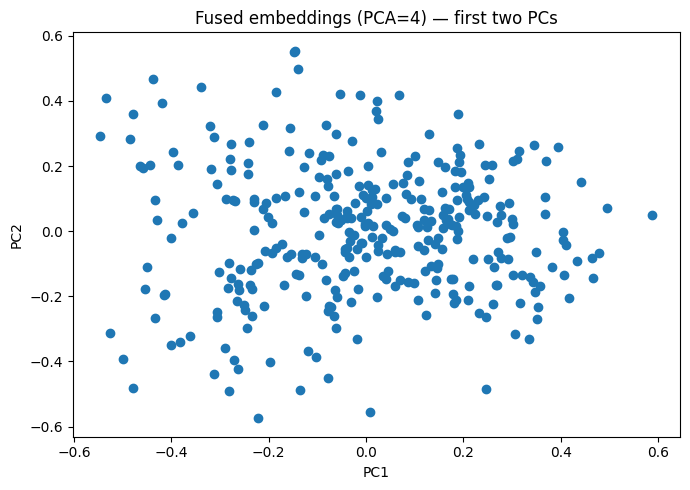

Saved figure: /Users/sarveshaks/Documents/Documents - Sarvesha’s MacBook Pro (2)/Project Stea/project_x/data_cleaned/figs/fused_pca_scatter_pc12_k4.png


In [17]:
best_pca = max(pca_scores, key=lambda d: (round(d['silhouette'],4), round(d['var_explained'],4)))['k']
pca, Z = pca_models[best_pca]
print('Chosen PCA components:', best_pca)

# Plot 2D if k>=2; if k>2 we still plot the first two PCs for a quick view
plt.figure(figsize=(7,5))
plt.scatter(Z[:,0], Z[:,1])
plt.title(f"Fused embeddings (PCA={best_pca}) — first two PCs")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
fig_path = FIG_DIR / f"fused_pca_scatter_pc12_k{best_pca}.png"
plt.savefig(fig_path)
plt.show()
print('Saved figure:', fig_path)

## Step 5 — Clustering experiments (KMeans vs DBSCAN)
We try **KMeans** with `k ∈ {6, 8, 10}` and **DBSCAN** with `(eps, min_samples) ∈ {(0.5,5), (0.7,5), (0.7,10)}` on the chosen PCA space `Z`. We compare **silhouette** and **homogeneity** vs the pseudo-labels `y`.

In [18]:
cluster_results = []

# KMeans sweep
for k in [6,8,10]:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(Z)
    try:
        sil = silhouette_score(Z, labels)
    except Exception:
        sil = -1
    try:
        homo = homogeneity_score(y, labels)
    except Exception:
        homo = -1
    cluster_results.append({'algo':'kmeans','k':k,'silhouette':sil,'homogeneity':homo})

# DBSCAN sweep
for eps in [0.5, 0.7]:
    for ms in [5, 10]:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(Z)
        # valid silhouette requires >1 cluster and no all -1
        try:
            if len(set(labels)) > 1 and (set(labels) - {-1}):
                sil = silhouette_score(Z[labels!=-1], labels[labels!=-1])
            else:
                sil = -1
        except Exception:
            sil = -1
        try:
            homo = homogeneity_score(y[labels!=-1], labels[labels!=-1]) if (labels!=-1).any() else -1
        except Exception:
            homo = -1
        cluster_results.append({'algo':'dbscan','eps':eps,'min_samples':ms,'silhouette':sil,'homogeneity':homo})

pd.DataFrame(cluster_results)

,algo,k,silhouette,homogeneity,eps,min_samples
0,kmeans,6.0,0.257074,0.016369,NaN,NaN
1,kmeans,8.0,0.252132,0.046039,NaN,NaN
2,kmeans,10.0,0.250676,0.042951,NaN,NaN
3,dbscan,NaN,-1.000000,0.000000,0.5,5.0
4,dbscan,NaN,-1.000000,0.000000,0.5,10.0
5,dbscan,NaN,-1.000000,0.000000,0.7,5.0
6,dbscan,NaN,-1.000000,0.000000,0.7,10.0


**Selection rationale:**
- Primary: **higher silhouette** (better cluster separation in the chosen space).
- Secondary: **higher homogeneity** vs pseudo-labels (consistency with sensory dominance).

Chosen clustering: {'algo': 'kmeans', 'k': 6, 'silhouette': 0.2570740541682289, 'homogeneity': 0.016369222481889226}


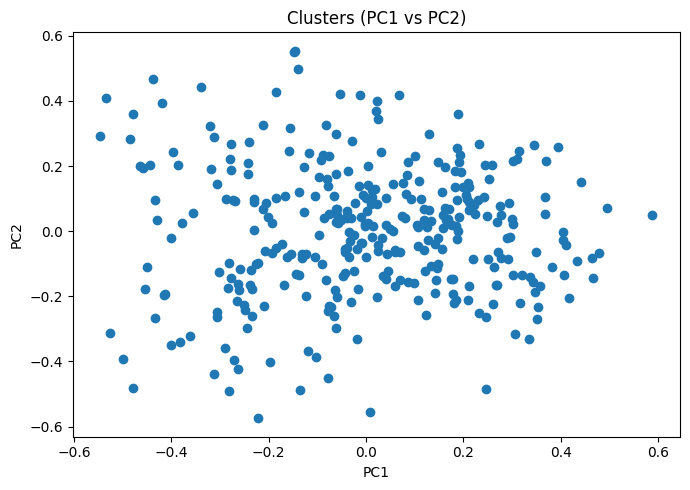

Saved figure: /Users/sarveshaks/Documents/Documents - Sarvesha’s MacBook Pro (2)/Project Stea/project_x/data_cleaned/figs/clusters_pc12.png


In [19]:
# Select best clustering config
def score_tuple(rec):
    return (round(rec['silhouette'] if rec['silhouette'] is not None else -1, 4),
            round(rec['homogeneity'] if rec['homogeneity'] is not None else -1, 4))

best_cluster = max(cluster_results, key=score_tuple)
print('Chosen clustering:', best_cluster)

# Fit it again to get labels for export
if best_cluster['algo'] == 'kmeans':
    km = KMeans(n_clusters=best_cluster['k'], n_init=10, random_state=42)
    labels = km.fit_predict(Z)
else:
    db = DBSCAN(eps=best_cluster['eps'], min_samples=best_cluster['min_samples'])
    labels = db.fit_predict(Z)

# Plot clusters in PC1-PC2 view
plt.figure(figsize=(7,5))
plt.scatter(Z[:,0], Z[:,1])
plt.title('Clusters (PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
fig2 = FIG_DIR / 'clusters_pc12.png'
plt.savefig(fig2)
plt.show()
print('Saved figure:', fig2)

## Step 6 — Save fused embeddings and configuration
We export fused XD vectors, router weights, labels, PCA coordinates, and chosen hyperparameters to files in `data_cleaned/`.

In [20]:
emb_df = pd.DataFrame({
    'pca_pc1': Z[:,0],
    'pca_pc2': Z[:,1],
})
if Z.shape[1] >= 3:
    emb_df['pca_pc3'] = Z[:,2]
if Z.shape[1] >= 4:
    emb_df['pca_pc4'] = Z[:,3]

emb_df['w_taste'] = weights[:,0]
emb_df['w_aroma'] = weights[:,1]
emb_df['w_texture'] = weights[:,2]
emb_df['dominant'] = df_all['dominant'].values
emb_df['cluster_label'] = labels

OUT_CSV = DATA_CLEANED / 'moe_embeddings.csv'
emb_df.to_csv(OUT_CSV, index=False)
print('Saved embeddings to:', OUT_CSV)

config = {
    'vectorizer': best['opt'],
    'router': best_router,
    'svd_dim': int(best_svd_dim),
    'pca_components': int(best_pca),
    'clustering': best_cluster,
    'n_rows_input': int(len(df)),
    'n_rows_used': int(len(df_all))
}
OUT_CFG = DATA_CLEANED / 'moe_config.json'
with open(OUT_CFG, 'w', encoding='utf-8') as f:
    json.dump(config, f, ensure_ascii=False, indent=2)
print('Saved config to:', OUT_CFG)

Saved embeddings to: /Users/sarveshaks/Documents/Documents - Sarvesha’s MacBook Pro (2)/Project Stea/project_x/data_cleaned/moe_embeddings.csv
Saved config to: /Users/sarveshaks/Documents/Documents - Sarvesha’s MacBook Pro (2)/Project Stea/project_x/data_cleaned/moe_config.json


## Step 7 — Brief rationale (auto-generated)
- Vectorizer + router were chosen by **validation accuracy** across alternatives.
- Expert SVD dimension chosen by **silhouette** on fused embeddings.
- PCA components chosen by a tie-break between **silhouette** and **explained variance**.
- Clustering choice decided by **silhouette** and **homogeneity**.

This creates a defensible experimental path, aligned with the professor’s guidance for rigor and clear *why* at each step.

In [21]:
from sklearn.cluster import SpectralClustering
import numpy as np

for n in [4,6,8]:
    sc = SpectralClustering(n_clusters=n, affinity='nearest_neighbors', random_state=42)
    labels = sc.fit_predict(Z)
    sil = silhouette_score(Z, labels)
    print(f"Spectral (k={n}): silhouette={sil:.3f}")


Spectral (k=4): silhouette=0.238
Spectral (k=6): silhouette=0.252
Spectral (k=8): silhouette=0.236


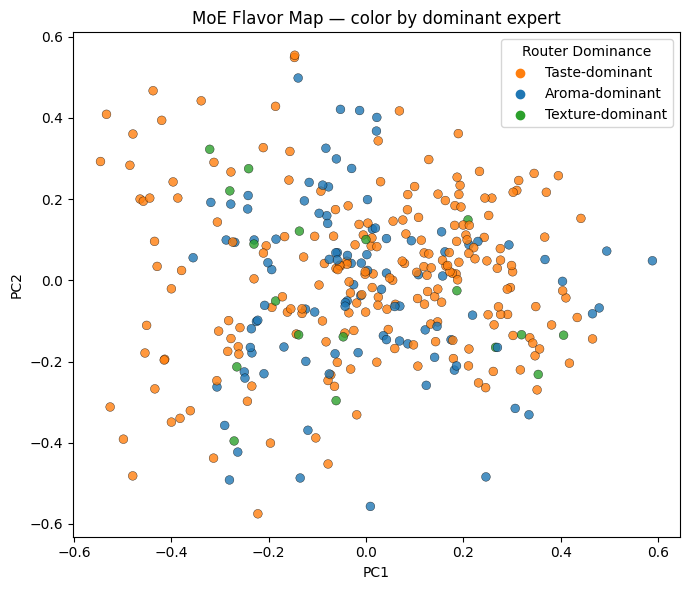

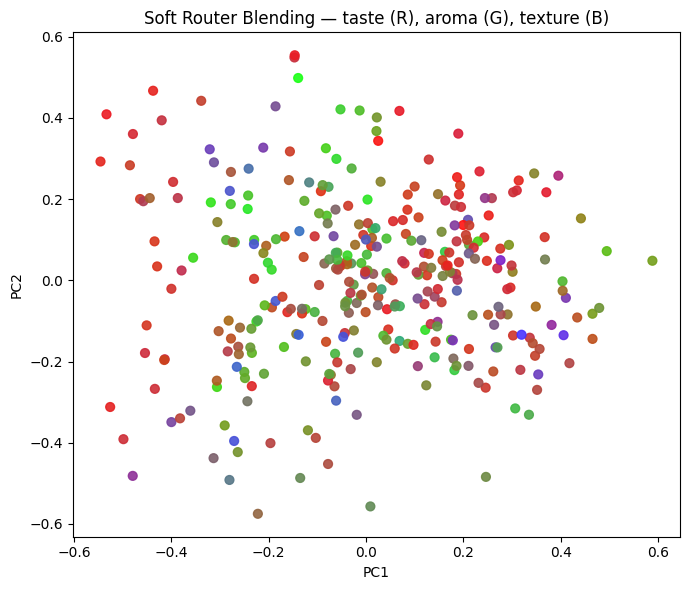

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# === Color by dominant expert ===
dominant_idx = np.argmax(weights, axis=1)
color_map = {0: "#ff7f0e", 1: "#1f77b4", 2: "#2ca02c"}  # taste=orange, aroma=blue, texture=green
labels_map = {0: "Taste-dominant", 1: "Aroma-dominant", 2: "Texture-dominant"}
colors = [color_map[i] for i in dominant_idx]

plt.figure(figsize=(7,6))
plt.scatter(Z[:,0], Z[:,1], c=colors, s=40, alpha=0.8, edgecolor='k', linewidth=0.3)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("MoE Flavor Map — color by dominant expert")
for k,v in labels_map.items():
    plt.scatter([],[], c=color_map[k], label=v)
plt.legend(title="Router Dominance")
plt.tight_layout()
plt.show()

# === Optional: visualize the continuous gating as RGB blend ===
# Map each expert weight to an RGB channel (taste→R, aroma→G, texture→B)
rgb_colors = np.clip(weights, 0, 1)
rgb_colors /= rgb_colors.max(axis=0)  # normalize channels
plt.figure(figsize=(7,6))
plt.scatter(Z[:,0], Z[:,1], color=rgb_colors, s=40, alpha=0.9)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Soft Router Blending — taste (R), aroma (G), texture (B)")
plt.tight_layout()
plt.show()


In [23]:

user_pref = weights.mean(axis=0)
user_pref /= user_pref.sum()  # normalize
print("User sensory preference:", dict(zip(["taste","aroma","texture"], user_pref)))


User sensory preference: {'taste': 0.520828803074512, 'aroma': 0.33334074403112623, 'texture': 0.14583045289436172}


In [26]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

# --- Run spectral clustering for multiple k and keep the best ---
best_sil = -1
best_k = None
best_labels = None

for n in [4, 6, 8]:
    sc = SpectralClustering(n_clusters=n, affinity='nearest_neighbors', random_state=42)
    labels = sc.fit_predict(Z)
    sil = silhouette_score(Z, labels)
    print(f"Spectral (k={n}): silhouette={sil:.3f}")
    
    if sil > best_sil:
        best_sil = sil
        best_k = n
        best_labels = labels

# --- Store the best labels ---
spectral_labels = best_labels
print(f"\n✅ Best Spectral clustering: k={best_k}, silhouette={best_sil:.3f}")

# --- Summarize cluster sensory composition ---
cluster_df = pd.DataFrame(weights, columns=["taste","aroma","texture"])
cluster_df["cluster"] = spectral_labels

cluster_summary = cluster_df.groupby("cluster").mean().sort_index()
cluster_summary = cluster_summary.assign(
    dominant_axis = cluster_summary[["taste","aroma","texture"]].idxmax(axis=1)
)

print("\nCluster-level sensory composition:")
display(cluster_summary.style.background_gradient(cmap='viridis'))

# --- Optional: count how many dishes per cluster ---
cluster_counts = cluster_df["cluster"].value_counts().sort_index()
print("\nCluster sizes:")
display(cluster_counts)


Spectral (k=4): silhouette=0.238
Spectral (k=6): silhouette=0.252
Spectral (k=8): silhouette=0.236

✅ Best Spectral clustering: k=6, silhouette=0.252

Cluster-level sensory composition:


,taste,aroma,texture,dominant_axis
cluster,,,,
0,0.527194,0.311243,0.161563,taste
1,0.524148,0.269880,0.205972,taste
2,0.512721,0.365244,0.122036,taste
3,0.501099,0.344424,0.154477,taste
4,0.536427,0.317837,0.145736,taste
5,0.521545,0.339676,0.138779,taste



Cluster sizes:


cluster
0    58
1    22
2    95
3    42
4    72
5    47
Name: count, dtype: int64